In [11]:
%load_ext autoreload
%autoreload 2

# PriorVAE: comparing training with new data on every epoch (i.e. every training step = new data), vs reusing the same data on each epoch

In [12]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [13]:
path = "./learnt_models/07_args_shorter_training.dill" # note test = train losses, by accident
path = "./learnt_models/07/07_args_correct_test-train.dill" # corrected from above 

with open(path, "rb") as f:
    args = dill.load(f)


In [14]:
print(args)

{'n': 100, 'gp_kernel': <function esq_kernel at 0x7fa5e031d2d0>, 'rng_key': Array([0, 2], dtype=uint32), 'x': Array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.09999999, 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.19999999, 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.39999998, 0.41      , 0.42      , 0.42999998, 0.44      ,
       0.45      , 0.45999998, 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.59999996, 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 

In [15]:

from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training,  plot_draws, plot_draws_hpdi

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

# Comparing training plots

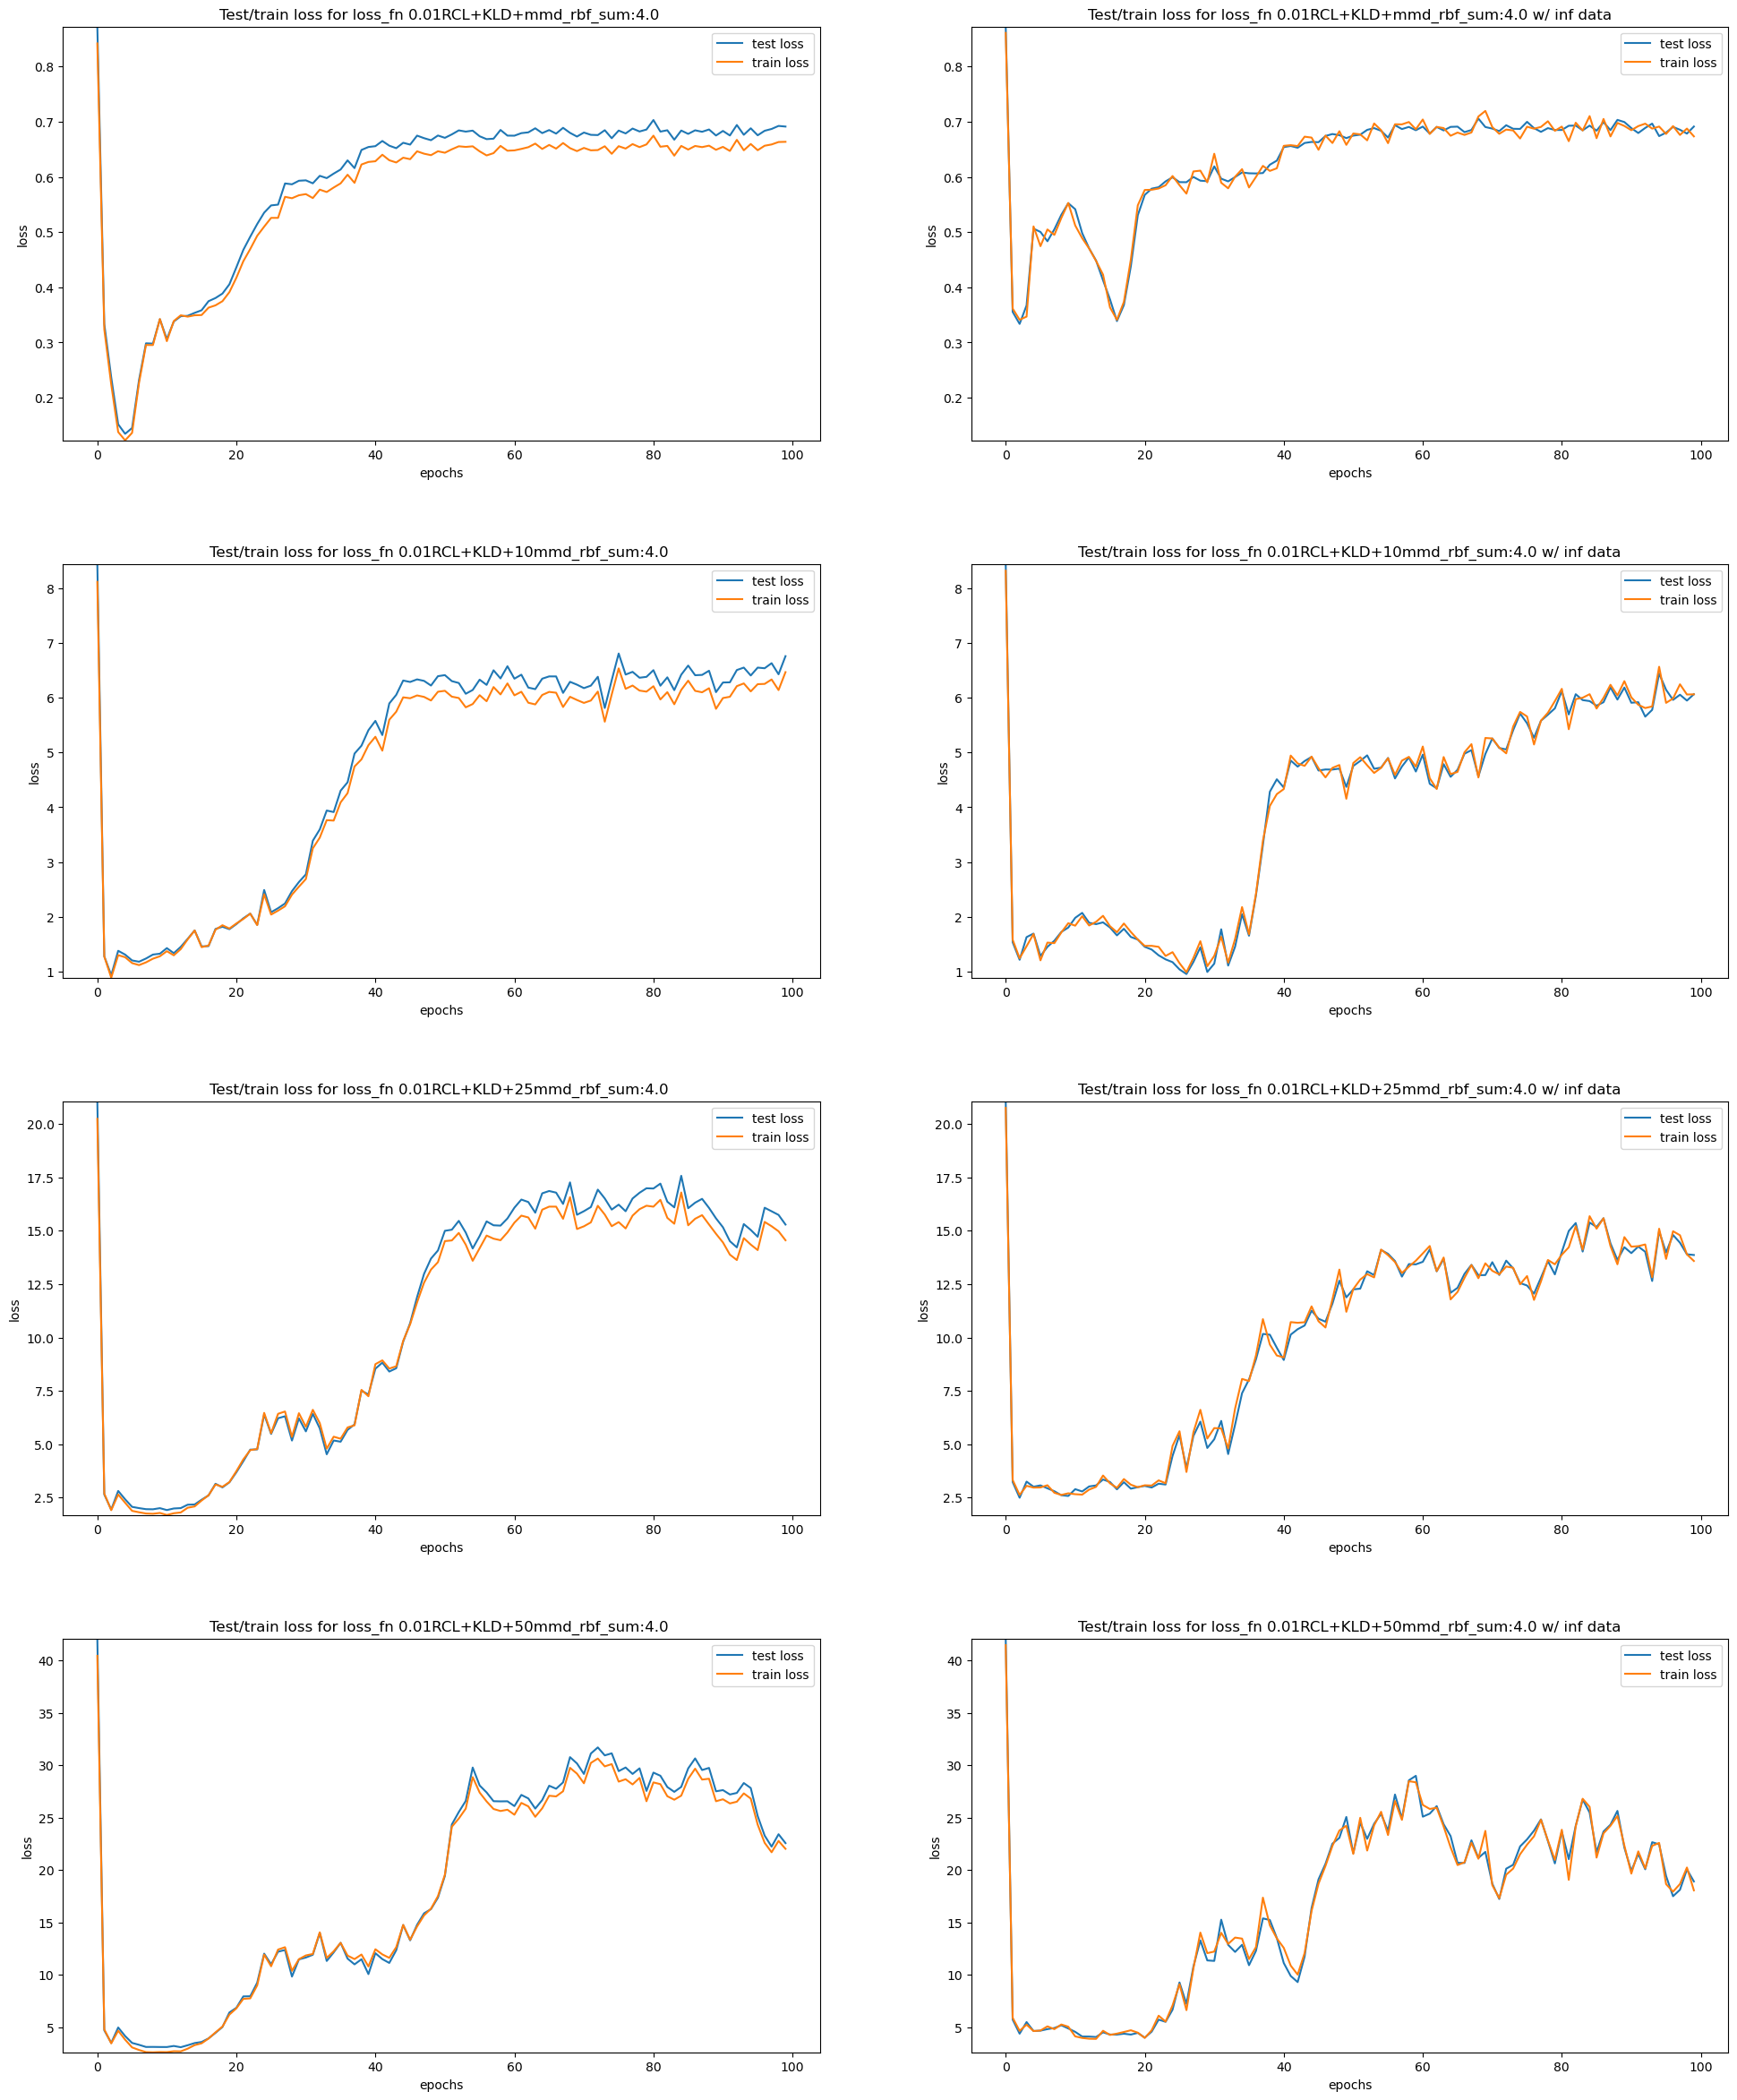

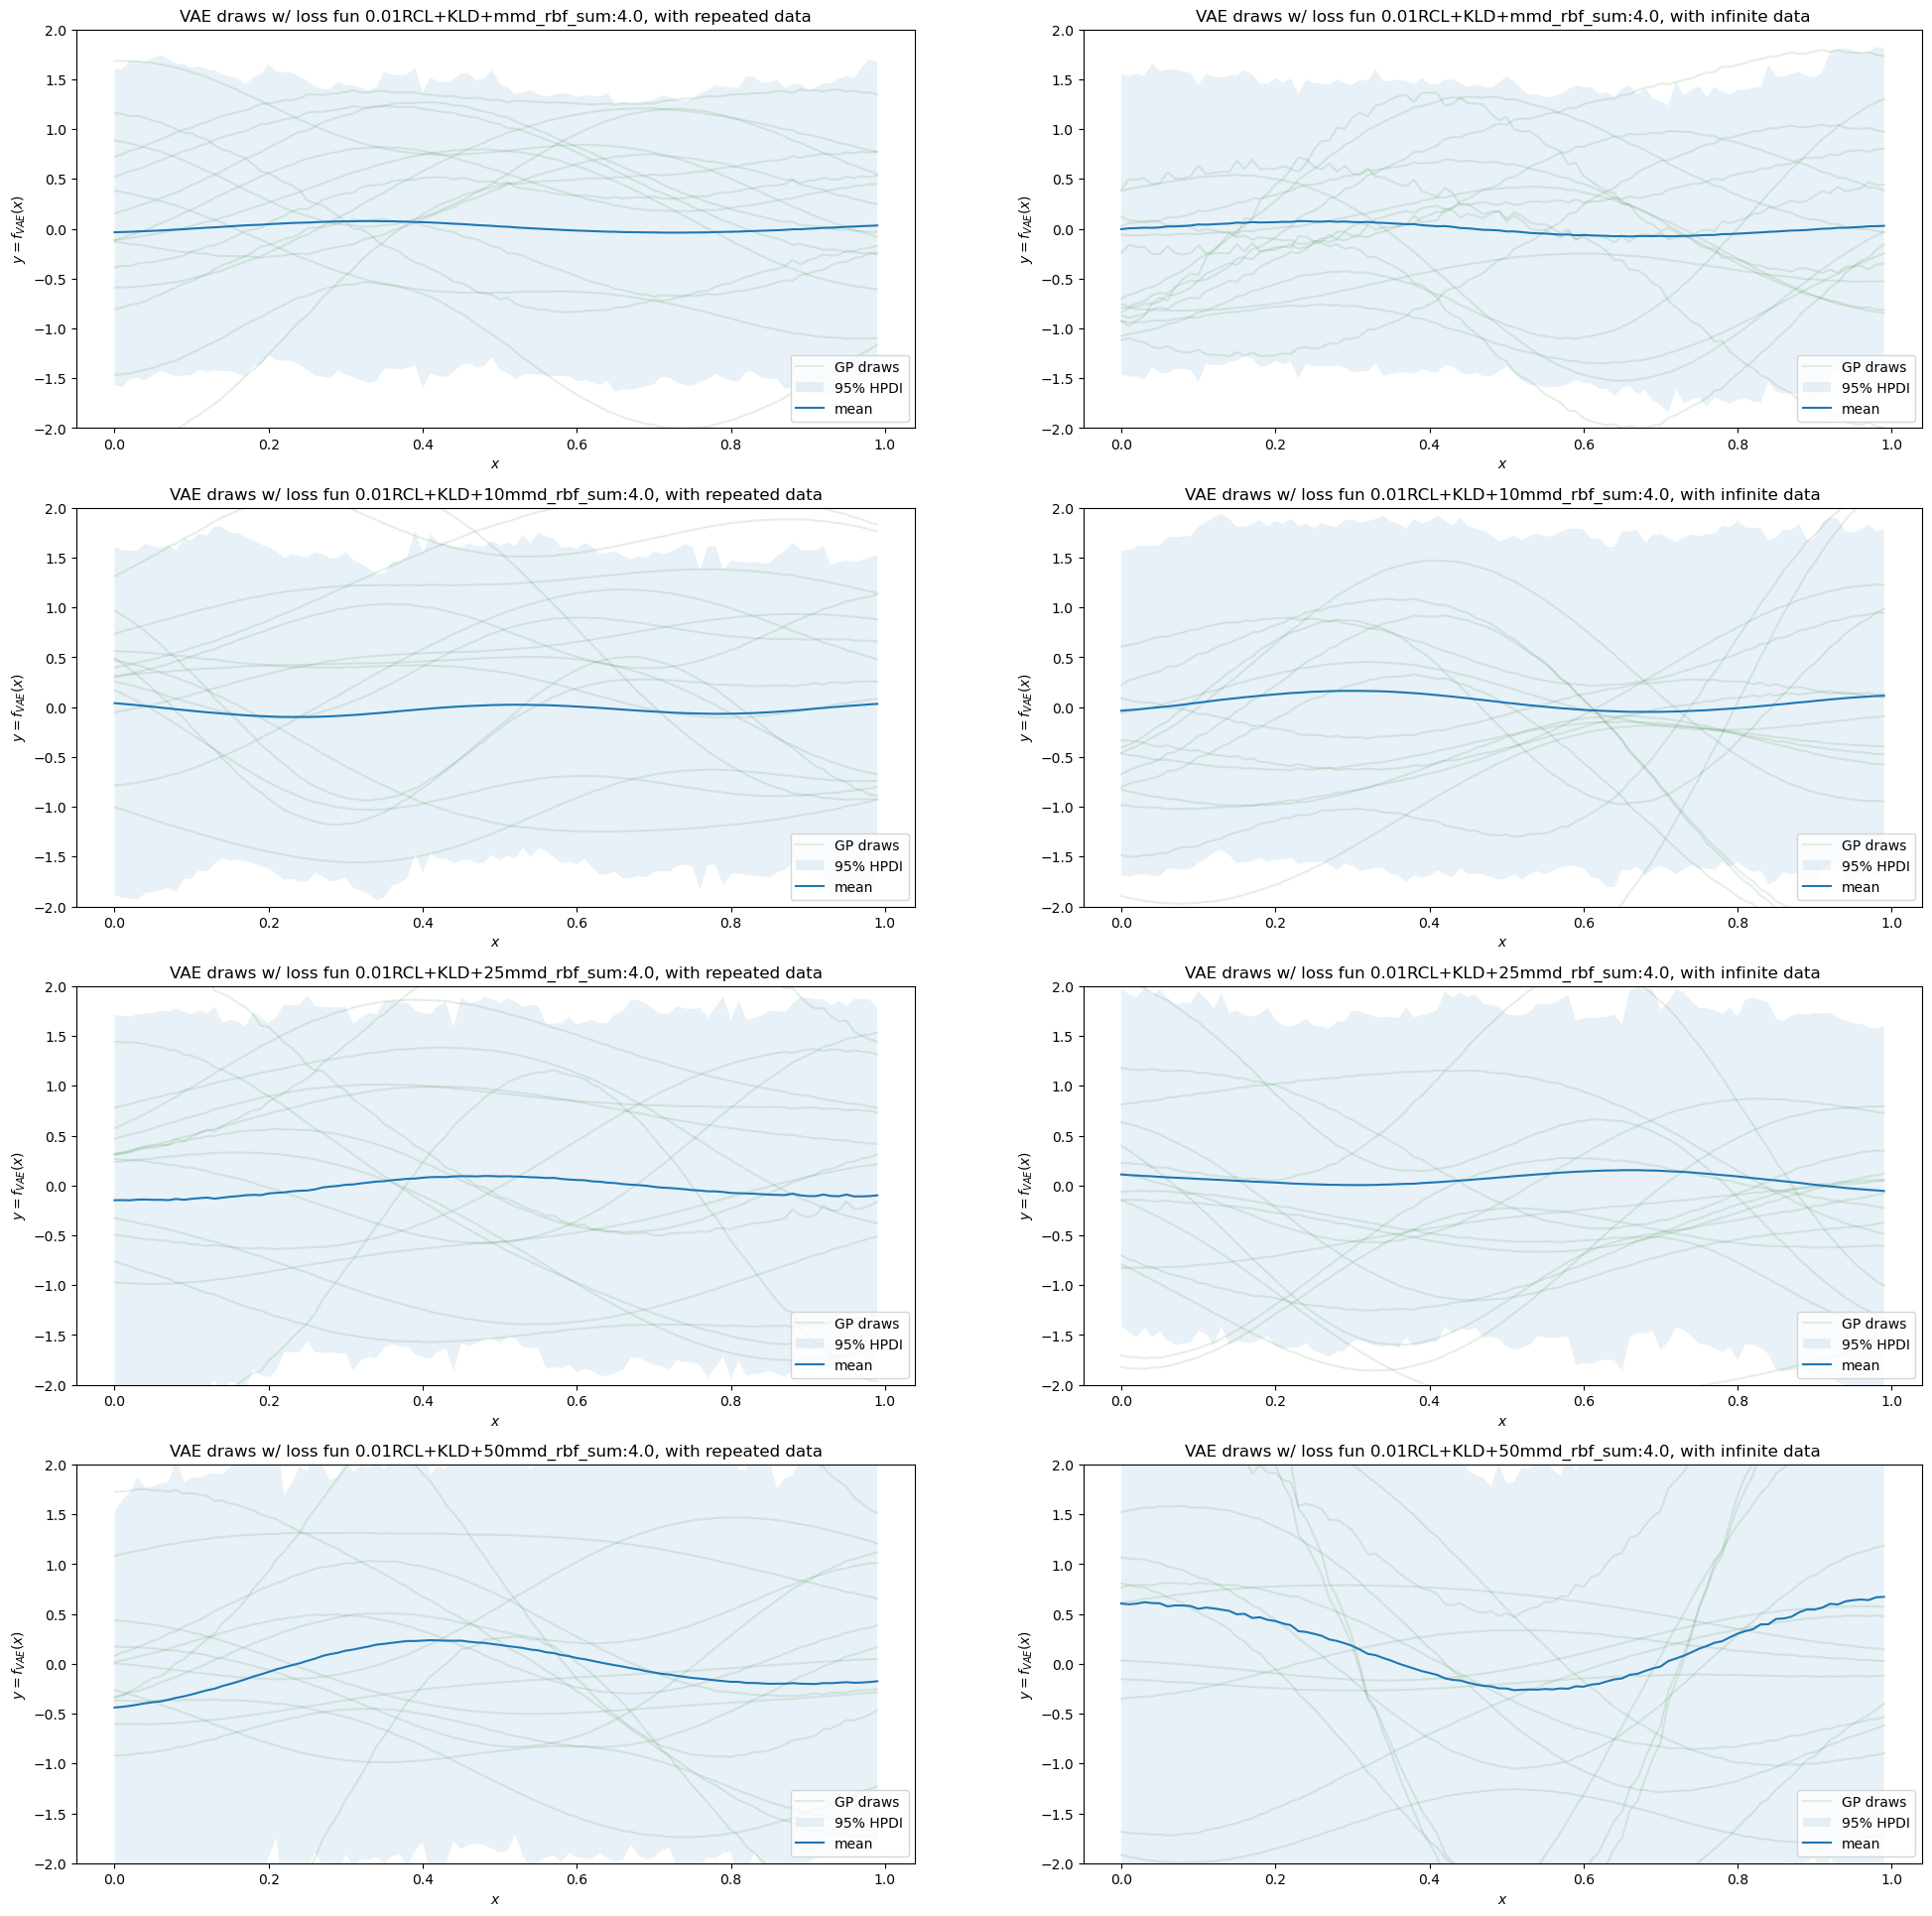

In [17]:
from plotting.plots import plot_training_pair

fig = plt.figure(figsize=(24,24))
training_figs = fig.subfigures(nrows=len(args["loss_functions"]), ncols=1)

draws_fig, draws_axs = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(24,24))

for i, loss_fn in enumerate(args["loss_functions"]):

    file_path = f'{get_savepath()}/{decoder_filename("07/07", args, suffix=loss_fn+"_metrics_hist")}'

    try: 
        with open(file_path, 'rb') as file:
            metrics_history = dill.load(file)
        with open(file_path + "_inf", 'rb') as file:
            inf_metrics_history = dill.load(file)

        plot_training_pair(
            metrics_history["test_loss"], 
            metrics_history["train_loss"], 
            inf_metrics_history["test_loss"], 
            inf_metrics_history["train_loss"], 
            f"Test/train loss for loss_fn {loss_fn} ",
            f"Test/train loss for loss_fn {loss_fn} w/ inf data",
            "loss",
            fig = training_figs[i]
        )

    except FileNotFoundError:
        print(f"Failed to load metrics history for loss_fn={loss_fn}, j={j}")

    for j in [0,1]:
        infinite = j ==1
        path_inf = "_inf" if infinite else ""
        str_inf = "with infinite data" if infinite else "with repeated data"

        

        file_path = f'{get_savepath()}/{decoder_filename("07/07", args, suffix=loss_fn+path_inf)}'

        try:
            dummy_decoder = VAE_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            plot_draws_hpdi(vae_draws, args["x"], f"VAE draws w/ loss fun {loss_fn}, {str_inf}", "$y=f_{VAE}(x)$", ax=draws_axs[i, j])
        except FileNotFoundError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")